In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [2]:
data = pd.read_pickle('../../data/processed/all_samples.pickle')
data['datetime'] = pd.to_datetime(data.date)
data['day'] = data.datetime.dt.weekday_name
data = pd.get_dummies(data, prefix='day', columns=['day'])

In [3]:
features = ['hour',
            'daylight_yn',
            'holiday_yn',
            'rush_hour_yn',
            'temp',
            'wind_speed',
            'precipitation',
            'road_length',
            'class_freeway',
            'class_local',
            'class_major',
            'class_other',
            'class_unimproved',
            'day_Monday',
            'day_Tuesday',
            'day_Wednesday',
            'day_Thursday',
            'day_Friday',
            'day_Saturday',
            'day_Sunday']

labels = 'accident_yn'

In [4]:
X = data[features]
y = data[labels]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [6]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

print('Random Forest (n=100)')

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))

feature_importance = pd.Series(forest.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance)

Random Forest (n=100)
Accuracy: 0.828506238739118
Precision: 0.6807163780053866
Recall: 0.5856604028888927
road_length         0.425048
temp                0.156232
wind_speed          0.098980
class_major         0.094446
hour                0.082337
class_local         0.061327
precipitation       0.013708
daylight_yn         0.011967
class_freeway       0.010668
class_unimproved    0.007682
holiday_yn          0.006807
rush_hour_yn        0.004958
day_Sunday          0.003734
day_Monday          0.003699
day_Tuesday         0.003684
day_Wednesday       0.003595
day_Thursday        0.003592
day_Friday          0.003348
day_Saturday        0.003213
class_other         0.000974
dtype: float64


In [7]:
# Current Parameters
pprint(forest.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [8]:
# Random Search

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=50, stop=150, num=5)]

# Number of features to consider at each split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 32, 55, 77, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 75, 100, 125, 150]}


In [9]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter=20,
                               n_jobs=-1,
                               cv=3,
                               verbose=2,
                               random_state=42)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 29.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [50, 75, 100, 125, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 32, 55, 77, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [10]:
# save results of 30 min worth of processing...
import pickle
f = open('../../data/processed/rf_random.pickle', 'wb')
pickle.dump(rf_random, f)
f.close()

In [11]:
rf_random.cv_results_

C:\Users\kgerig\AppData\Local\Continuum\anaconda3\envs\nola-traffic\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\kgerig\AppData\Local\Continuum\anaconda3\envs\nola-traffic\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\kgerig\AppData\Local\Continuum\anaconda3\envs\nola-traffic\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, plea

{'mean_fit_time': array([120.66621788,  87.60306644,  96.56256827,  78.44037096,
         74.28683305,  40.37229403,  75.38606469, 136.97877407,
         71.52505724, 128.59401194, 127.26965404,  42.48784479,
        163.46413962,  93.7450339 ,  37.33905435,  97.92983381,
         96.39585861,  39.37368735, 105.36241134, 116.6183455 ]),
 'std_fit_time': array([ 1.45931728,  3.28129836,  2.87981557,  5.40576849,  1.41437056,
         0.41500699,  0.85944904,  1.79956527,  1.21318649,  0.74175885,
         0.17845852,  0.58078096,  3.13106843,  1.8678011 ,  0.44073701,
         0.90067101,  3.36640029,  0.72143021,  2.4995364 , 10.79367245]),
 'mean_score_time': array([10.2519207 ,  4.54514138,  6.96466621,  3.31612643,  6.20296272,
         2.08461634,  7.4802777 , 11.32890177,  5.93597444, 11.07315175,
        10.09264167,  2.42751201, 14.13281298,  8.69779476,  4.45724034,
         7.66253146,  9.32134477,  3.91333779,  8.52027877,  7.00508451]),
 'std_score_time': array([0.03171942, 

In [18]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    test_scores = model.cv_results_['mean_test_score']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)


In [16]:
'param_%s' % 'n_estimators'

'param_n_estimators'

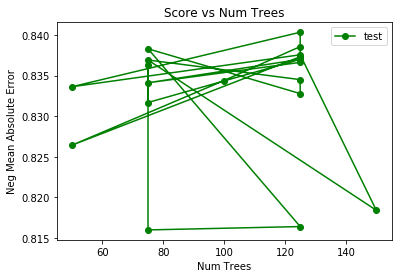

In [20]:
plot_results(rf_random)

In [17]:
#test_scores = rf_random.cv_results_['mean_test_score']
rf_random.cv_results_['param_n_estimators']

masked_array(data=[125, 125, 75, 125, 75, 75, 75, 125, 75, 125, 125, 75,
                   150, 125, 50, 125, 125, 50, 100, 125],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object)

C:\Users\kgerig\AppData\Local\Continuum\anaconda3\envs\nola-traffic\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


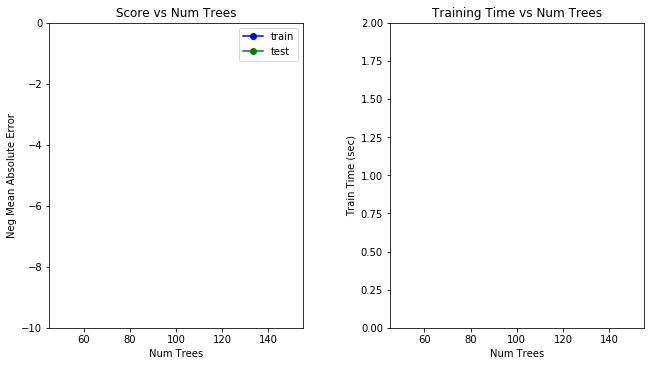

In [13]:
plot_results(rf_random)

In [16]:
pprint(rf_random.best_params_)

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 125}


In [17]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = 100 * metrics.accuracy_score(test_labels, predictions)
    precision = 100 * metrics.precision_score(test_labels, predictions)
    recall = 100 * metrics.recall_score(test_labels, predictions)

    print('Model Performance')
    print('Accuracy:\t{:0.2f}%.'.format(accuracy))
    print('Precision:\t{:0.2f}%.'.format(precision))
    print('Recall:\t{:0.2f}%.'.format(recall))

    return (accuracy, precision, recall)


In [18]:
base_model = RandomForestClassifier(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)
base_performance = evaluate(base_model, X_test, y_test)

Model Performance
Accuracy:	82.85%.
Precision:	68.07%.
Recall:	58.57%.


In [19]:
best_random = rf_random.best_estimator_
random_performance = evaluate(best_random, X_test, y_test)

Model Performance
Accuracy:	84.23%.
Precision:	72.33%.
Recall:	59.33%.


In [20]:
improvement_accuracy = 100 * (random_performance[0] - base_performance[0]) / base_performance[0]
improvement_precision = 100 * (random_performance[1] - base_performance[1]) / base_performance[1]
improvement_recall = 100 * (random_performance[2] - base_performance[2]) / base_performance[2]

print('Accuracy Improvement:\t{:0.2f}%.'.format(improvement_accuracy))
print('Precision Improvement:\t{:0.2f}%.'.format(improvement_precision))
print('Recall Improvement:\t{:0.2f}%.'.format(improvement_recall))

Accuracy Improvement:	1.66%.
Precision Improvement:	6.26%.
Recall Improvement:	1.30%.


In [21]:
feature_importance_best = pd.Series(best_random.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance_best)

road_length         0.402501
class_major         0.153864
class_local         0.125439
temp                0.083956
hour                0.077053
wind_speed          0.057979
daylight_yn         0.022670
class_unimproved    0.015779
class_freeway       0.015053
precipitation       0.008216
rush_hour_yn        0.006984
day_Sunday          0.004691
holiday_yn          0.004369
day_Saturday        0.003611
day_Tuesday         0.003165
day_Monday          0.003143
day_Wednesday       0.003131
day_Thursday        0.003121
day_Friday          0.003031
class_other         0.002244
dtype: float64
